# 正则化


在深度学习课程中，我们了解到神经网络在解决各种问题时非常有效。然而，某些主要问题限制了它们的潜力。今天我们将讨论**过拟合（overfitting）**。

**过拟合**发生在模型过度适应训练数据时，甚至捕捉到了异常值和噪声。结果，模型在测试数据上的表现变差。

![过拟合示意图](./images/overfitting.png)

这个问题在训练神经网络时很常见。为了监控它，我们使用一个验证数据集，定期评估以确保损失（loss）确实在减少。当出现过拟合时，训练和验证的损失曲线如下所示：

![过拟合曲线](./images/overfittingcurve.png)

训练损失继续下降，而验证损失却开始上升。这表明模型正在学习训练数据的特定细节，这与我们的目标相反。

仔细思考一下，这是合理的：模型试图最小化训练数据上的损失。

这是训练神经网络时需要考虑的一个关键点。为了应对这个问题，有几种技术可用。我们将在这里介绍其中两种，并尝试理解它们为何有效。

这两种方法是：**L2 正则化**和**Dropout**。本笔记本参考了 [fastai 课程](https://github.com/fastai/fastbook/tree/master)。


## L2 正则化


**L2 正则化**是一种简单的技术。它通过在损失函数中添加权重平方和（乘以一个称为 *weight_decay* 的系数 $wd$）来实现。这个额外项推动权重尽可能小。


### 为什么能减少过拟合？


直观上，较大的权重可能会导致损失函数中的陡峭斜率。

为了验证这一点，我们来看抛物线函数：
$y = a \times x^2$


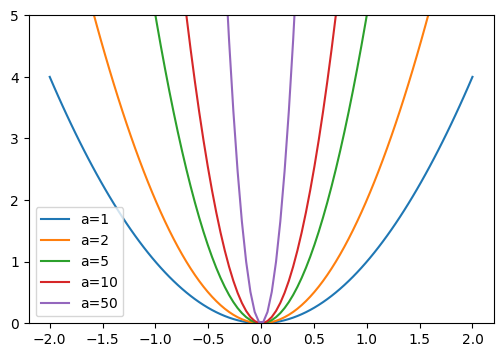

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(6,4))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

$a$ 越大，抛物线越陡峭。如果将 $a$ 与我们的权重进行类比，可以想象较大的权重会导致网络表示的函数出现急剧变化，这可能对应过拟合。

这个解释可能看起来有些“神奇”，但在实践中，L2 正则化确实能有效预防过拟合。

限制权重的大小虽然会降低网络的学习能力，但这种限制能提高模型的泛化能力，从而避免过拟合。


### 方法实现


要实现 L2 正则化，可以手动将该项添加到损失函数中：
$L(w) = L_0(w) + wd \sum_{i=1}^{n} w_i^2$，其中 $L(w)$ 是正则化后的损失，$L_0(w)$ 是经典损失函数，$wd$（即 *weight_decay*）是正则化系数，$w_i$ 是模型的某个权重。
在 Python 中，可以这样实现：```loss_regu = loss + wd * (parameters**2).sum()```。

更简单的方法是，在 PyTorch 中使用 *weight_decay* 参数初始化优化器（默认为 0）。例如：


In [ ]:
import torch
params=torch.tensor([1.0], requires_grad=True)
# Pour SGD
torch.nn.optim.SGD(params, lr=0.1, weight_decay=0.1)
# Pour Adam
torch.nn.optim.Adam(params, lr=0.1, weight_decay=0.1)

如果你的模型存在过拟合问题，这是一个值得尝试的方法！


## Dropout


**Dropout** 是一种正则化方法，首次提出于论文《[通过防止特征检测器的共同适应来改进神经网络](https://arxiv.org/pdf/1207.0580)》。其核心思想很简单：在每个训练步骤中，随机将网络中部分激活值置零。这样，每个神经元都必须从输入中产生一致的输出。

![Dropout 示意图](./images/dropout.png)


### 直观理解


为了理解 **Dropout**，我们可以借用论文作者（Geoffrey Hinton）的一个比喻：

*“我去了银行。柜员不断变换，我问其中一位原因。他说不知道，但他们经常被轮岗。我想这是因为，如果要实施银行欺诈，员工之间需要合谋，而频繁轮岗大大降低了这种可能性。这让我意识到，在每个样本中随机去除不同的神经元子集，可以阻止它们‘合谋’，从而减少过拟合。”*

这个比喻说明，Dropout 防止神经元“作弊”，即依赖输入中的某个细节来预测。这种方法迫使神经元相互合作，并增加了激活值中的噪声，从而构建更鲁棒的模型。也可以将 Dropout 视为在测试阶段合作的多个小模型的混合。


### 实现


在 Python 中，可以这样实现 **Dropout**：


In [4]:
import torch.nn as nn
class Dropout(nn.Module):
  def __init__(self, p): 
    self.p = p
  def forward(self, x):
    # Le droupout n'est appliqué que pendant l'entrainement
    if not self.training: 
      return x
    # On crée un masque de dropout à partir d'une distribution de Bernoulli
    mask = torch.zeros_like(x)
    mask.bernoulli_(1 - self.p) # chaque élément a une probabilité de 1-p d'être mis à 0 sinon il est mis à 1
    # On applique le masque et on divise par 1-p pour garder une moyenne cohérente
    return x * mask/(1-self.p)

PyTorch 中也实现了 Dropout 层，可以通过 [nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) 使用，其中参数 $p$ 表示激活值被置零的概率。

**注意**：在 PyTorch 中使用 Dropout 时，必须确保在训练时将模型设为训练模式，在验证/测试时设为评估模式（类似于 *BatchNorm*）。可以通过 ```model.train()``` 和 ```model.eval()``` 来切换模式。
